In [118]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy
from scipy.sparse import coo_matrix

In [119]:
## load .npy data
X = np.load('../data/X_example.npy',allow_pickle=True)
X.shape

(45, 100)

In [120]:
def reverse_patches(X, N, M):
    # Convert sparse matrix to dense for easier manipulation
    X_dense = X.toarray()
    
    # Get the dimensions of the matrix
    rows, cols = X_dense.shape
    
    # Calculate the number of patches along rows and columns
    num_patches_row = rows // N
    num_patches_col = cols // M
    
    # Create a list to hold the patches
    patches = []

    # Extract patches and store them in the list
    for i in range(num_patches_row):
        for j in range(num_patches_col):
            patch = X_dense[i*N:(i+1)*N, j*M:(j+1)*M]
            patches.append(patch)
    
    # Reverse the order of patches
    patches_reversed = patches[::-1]
    
    # Reconstruct the matrix from reversed patches
    reconstructed_rows = []
    for i in range(num_patches_row):
        row_patches = patches_reversed[i*num_patches_col:(i+1)*num_patches_col]
        reconstructed_row = np.hstack(row_patches)
        reconstructed_rows.append(reconstructed_row)
    
    X_reconstructed = np.vstack(reconstructed_rows)
    
    # Convert back to sparse format
    X_reconstructed_sparse = coo_matrix(X_reconstructed)
    
    return X_reconstructed_sparse

In [121]:
def construct_X(M, alphas, Np=None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    if Np % 2 == 0:
        Np += 1

    # Coordinates of the tomogram's pixel centers, shifted so that the center pixel is at (0, 0)
    grid = np.mgrid[0:M, 0:M] - (M - 1) / 2
    C = np.vstack((grid[0].ravel(), grid[1].ravel()))

    D = M * M  # Number of pixels in the tomogram
    No = len(alphas)  # Number of projection angles
    N = No * Np  # Total number of sensor measurements
    
    # Initialize lists to collect the indices and weights of the non-zero elements in the sparse matrix
    i_indices = []
    j_indices = []
    weights = []

    # Sensor array's center coordinate
    s0 = (Np - 1) / 2

    for k, alpha in enumerate(alphas):
        # Convert angle from degrees to radians
        alpha_rad = np.deg2rad(alpha)
        # Compute the rotation matrix
        rotation_matrix = np.array([[np.cos(alpha_rad), -np.sin(alpha_rad)],
                                    [np.sin(alpha_rad),  np.cos(alpha_rad)]])
        # Rotate the pixel centers
        C_rotated = rotation_matrix @ C
        
        # Project the rotated pixel centers onto the sensor array
        p = C_rotated[1, :] + s0

        # Find the two closest sensor elements for each projection
        p_floor = np.floor(p).astype(int)
        p_ceil = np.ceil(p).astype(int)

        # Calculate distances to the closest sensor elements
        d_floor = p - p_floor
        d_ceil = p_ceil - p

        # Valid indices and weights for sensor elements
        valid_floor = (p_floor >= 0) & (p_floor < Np)
        valid_ceil = (p_ceil >= 0) & (p_ceil < Np)

        # Append valid indices and corresponding weights
        for j in range(D):
            if valid_floor[j]:
                i_indices.append(k * Np + p_floor[j])
                j_indices.append(j)
                weights.append(1 - d_floor[j])
            if valid_ceil[j]:
                i_indices.append(k * Np + p_ceil[j])
                j_indices.append(j)
                weights.append(1 - d_ceil[j])

    # Create the sparse matrix X
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
    X_reversed = reverse_patches(X, N, M)

    return X_reversed

In [122]:
design_matrix = construct_X(10, [-33, 1, 42], 15)
## convert to dense numpy array
design_matrix = design_matrix.toarray()


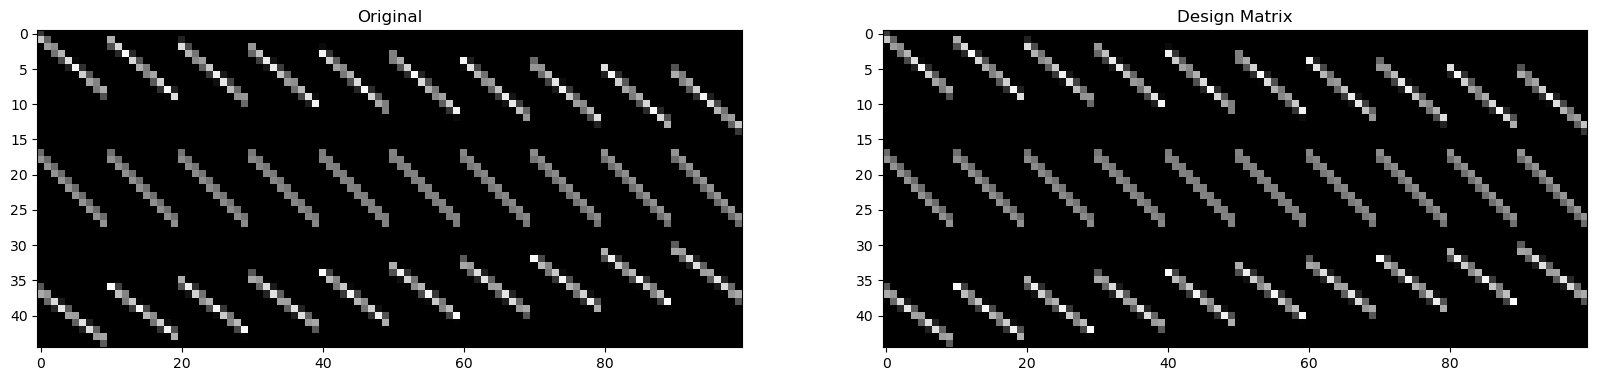

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(design_matrix, cmap='gray')
ax[1].set_title('Design Matrix')
plt.show()

#### Task 2

In [124]:
small_image= True

M = 195 ## 195

## load the data
data_path = "../data/"
X = None

if small_image:

    M = 77
    Np = 109
    No = 90

    alphas = np.load(data_path + "alphas_77.npy",allow_pickle=True)
    y = np.load(data_path + "y_77.npy",allow_pickle=True)
    X = np.load(data_path + "X_77.npy",allow_pickle=True)
    X = scipy.sparse.csc_matrix(X.all())
else:

    M = 195
    Np = 275
    No = 179

    alphas = np.load(data_path + "alphas_195.npy",allow_pickle=True)
    y = np.load(data_path + "y_195.npy",allow_pickle=True)
    X = construct_X(M, alphas,Np)
    X = scipy.sparse.csc_matrix(X)


print(scipy.sparse.issparse(X))
print("Indices of non zero elements:",scipy.sparse.find(X)[0],scipy.sparse.find(X)[1])
print("Number of non zero elements:",X.nnz)
print("Sparsity measure:",X.nnz/(X.shape[0]*X.shape[1]))

True
Indices of non zero elements: [  15   15   15 ... 9794 9794 9794] [ 0  1  2 ... 74 75 76]
Number of non zero elements: 1066978
Sparsity measure: 0.01834446316753001


In [125]:
'''
N = No X Np
D = M x M

X e de (No x Np) x (M x M)

Np e constant
No se schimba

y e de (No x Np) x 1
'''
print(y.shape)
print(alphas.shape)
print(X.shape)

(9810,)
(90,)
(9810, 5929)


In [126]:
design_matrix = X

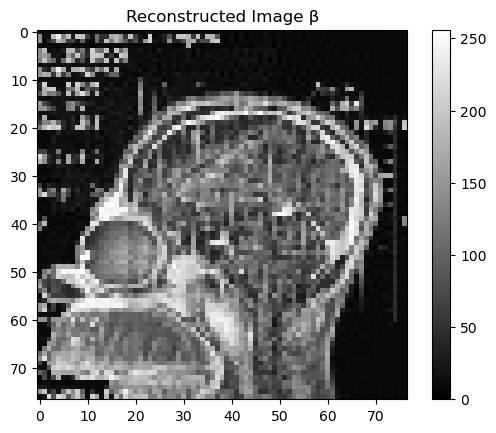

In [127]:
result = scipy.sparse.linalg.lsqr(design_matrix, y)
beta = result[0]
beta = beta.reshape(M,M)

## make beta in the range of 0 256
beta = beta - np.min(beta)
beta = beta / np.max(beta)
beta = beta * 256


# Visualize the reconstructed image
plt.imshow(beta, cmap='gray')
plt.title('Reconstructed Image β')
plt.colorbar()
plt.show()

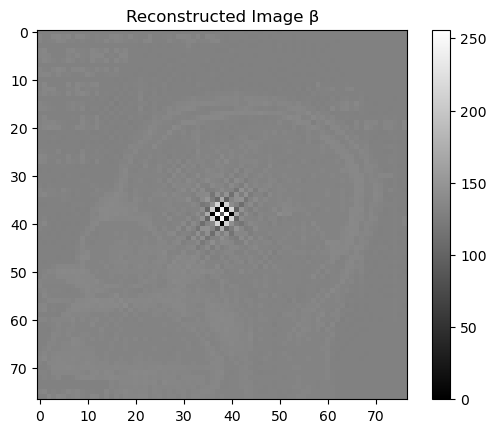

In [128]:
design_matrix = construct_X(M, alphas, Np)
design_matrix = scipy.sparse.csc_matrix(design_matrix)

result = scipy.sparse.linalg.lsqr(design_matrix, y)
beta = result[0]
beta = beta.reshape(M,M)

## make beta in the range of 0 256
beta = beta - np.min(beta)
beta = beta / np.max(beta)
beta = beta * 256


# Visualize the reconstructed image
plt.imshow(beta, cmap='gray')
plt.title('Reconstructed Image β')
plt.colorbar()
plt.show()

#### Task 3

In [129]:
## empiricaly I can determine a lower number of alpha, but what would be an analytical optimum

def subsample_projections(alphas, y, num_projections,Np):
    ## take the first num_projections angles
    alphas_sub = alphas[:num_projections]
    ## take the first num_projections * Np elements from y
    y_sub = y[:num_projections * Np]

    return alphas_sub, y_sub

def reconstruct_image(alphas, y, num_projections, M, Np):
    # Subsample the projections
    alphas_sub, y_sub = subsample_projections(alphas, y, num_projections,Np)

    print("Alphas_sub: ",len(alphas_sub))
    
    X_sub = construct_X(M, alphas_sub)  # This function needs to be defined based on your specific implementation
    
    print("X sub:",X_sub.shape)
    print("Y sub:",y_sub.shape)

    # Convert to sparse matrix
    X_sparse_sub = scipy.sparse.csc_matrix(X_sub)
    

    # Solve the least-squares problem
    result = scipy.sparse.linalg.lsqr(X_sparse_sub, y_sub)
    beta = result[0]
    
    # Reshape beta to the appropriate image dimensions
    beta_image = beta.reshape((M,M))
    
    return beta_image

Alphas_sub:  10
X sub: (1090, 5929)
Y sub: (1090,)
Alphas_sub:  20
X sub: (2180, 5929)
Y sub: (2180,)
Alphas_sub:  30
X sub: (3270, 5929)
Y sub: (3270,)
Alphas_sub:  40
X sub: (4360, 5929)
Y sub: (4360,)
Alphas_sub:  50
X sub: (5450, 5929)
Y sub: (5450,)
Alphas_sub:  60
X sub: (6540, 5929)
Y sub: (6540,)
Alphas_sub:  70
X sub: (7630, 5929)
Y sub: (7630,)
Alphas_sub:  77
X sub: (8393, 5929)
Y sub: (8393,)


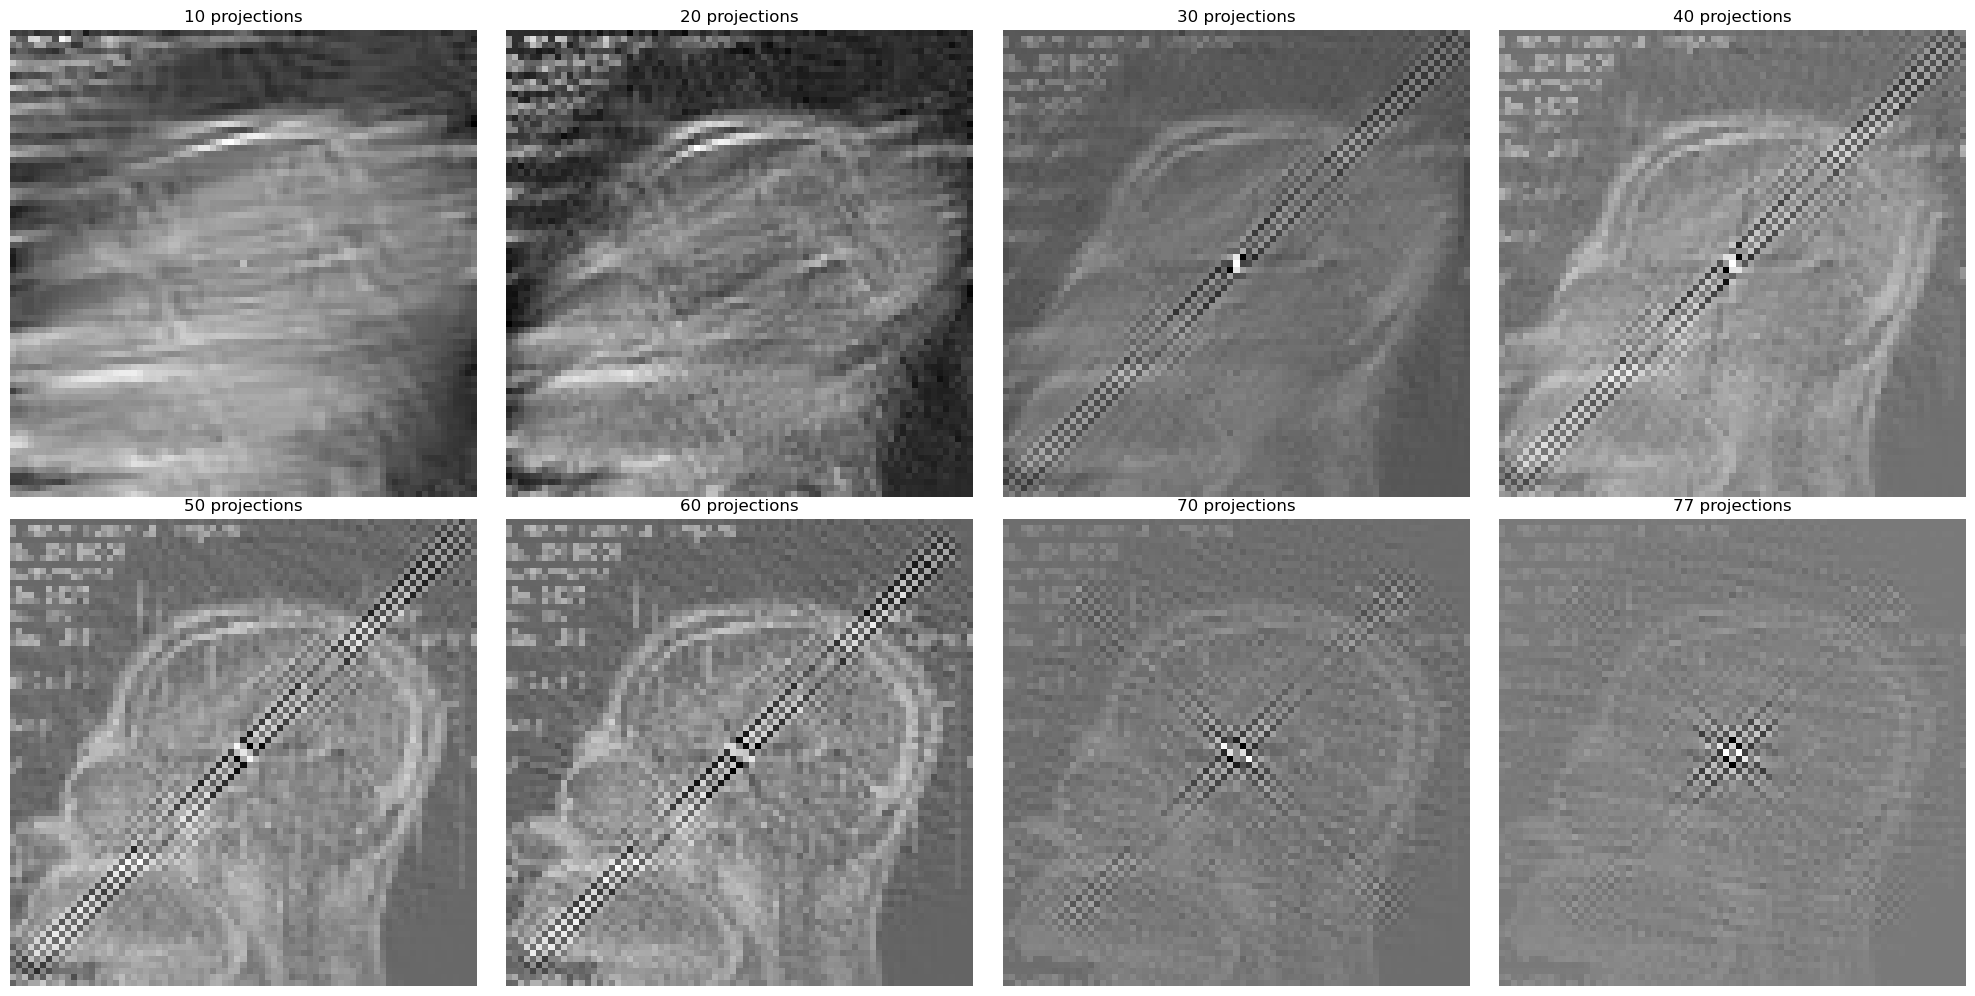

In [130]:
num_projections_list = [10, 20, 30, 40, 50, 60, 70, 77]


fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, num_projections in enumerate(num_projections_list):
    beta_image = reconstruct_image(alphas, y, num_projections, M, Np)
    ax = axes[i // 4, i % 4]
    ax.imshow(beta_image, cmap='gray')
    ax.set_title(f'{num_projections} projections')
    ax.axis('off')

plt.tight_layout()
plt.show()
